This is the Project that I've been working on while taking this [Course](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/200000-abstracts-for-seq-sentence-classification/200k_abstracts/test.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification/200k_abstracts/train.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification/200k_abstracts/dev.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification/Numbers_replaced_with_@/test.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification/Numbers_replaced_with_@/train.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification/Numbers_replaced_with_@/dev.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification/20k_abstracts_numbers_with_@/test.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification/20k_abstracts_numbers_with_@/train.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification/20k_abstracts_numbers_with_@/dev.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification/20k_abstracts/test.txt
/kaggle/input/200000-abstracts-for-seq-sentence-classification

In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir='../input/200000-abstracts-for-seq-sentence-classification/20k_abstracts_numbers_with_@/'


In [4]:
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['../input/200000-abstracts-for-seq-sentence-classification/20k_abstracts_numbers_with_@/test.txt',
 '../input/200000-abstracts-for-seq-sentence-classification/20k_abstracts_numbers_with_@/train.txt',
 '../input/200000-abstracts-for-seq-sentence-classification/20k_abstracts_numbers_with_@/dev.txt']

<h3>Preprocessing the Data

In [5]:
# Creating a function to read the txt Files
# This function returns all the lines in the txt file as a list
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

In [6]:
# Read the Lines in the Training Set
train_data_lines=get_lines(data_dir+"train.txt")
# train_data_lines[:20]

 <h4>
 Pre-processing the Data <br>
 List of dictionaries <br>
 Each line needs to be converted into a dictionary <br>
 Dictionary items are ordered, changeable, and does not allow duplicates.<br>
 Objectives, Methods, Results, Conclusins will all be Values to the 'TARGET' KEY<br>
 And the Text corresponding to them will be Values to the Key 'TEXT'<br>
 So each abstract would have about roughly 10-12 dicts for each statement<br>

In [7]:
# Preprocessing Functions
# Returns a list of dictionaries of abstract's lines
# Dict Format --> {'TARGET':'Background/Results/Objetive/Concludion','Text':'The actual statement'}
def preprocess_data(filename):
    input_lines=get_lines(filename)
    #This will be used to separte the abstracts from  one another using String mets
    abstract_lines=""
    # Empty list of abstracts
    abstract_samples=[]
    for line in input_lines:
        # Check for a new abstract
        if line.startswith("###"):
            abstract_id=line
            # And since we are in a new abstract we will Reset the abstract_lines
            abstract_lines=""
        # Check for a new line \n escape seq
        elif line.isspace():
            # Split the Lines of the abstract and will return a list of one abstract
            abstract_line_split=abstract_lines.splitlines()
            # Now we have to iterate through this singular abstract
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                #  Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object.
                # Create a empty Dict per line
                line_data={}
                # Split on the tab \t esc seq
                target_text_split=abstract_line.split("\t")
                # Get the Label of the sentence as the Label
                line_data["target"]=target_text_split[0]
                # Get the Text of the Lien as the Text Key
                line_data["text"]=target_text_split[1].lower()
                # Also adding the Line Nnumber as it will also aid the model
                line_data["line_number"]=abstract_line_number
                # Number of Lines in that particular abstract
                line_data["total_lines"]=len(abstract_line_split)-1
                # Now we have to append them to the absract_samples list
                abstract_samples.append(line_data)
        # So if both the cases are not there then the line is a labelled sentence
        else:
            abstract_lines+=line
    return abstract_samples
                
            
            

In [8]:
%%time
# Get the data and preprocess it
train_samples=preprocess_data(data_dir+"train.txt")
val_samples=preprocess_data(data_dir+"dev.txt")
test_samples=preprocess_data(data_dir+"test.txt")

CPU times: user 478 ms, sys: 97.6 ms, total: 575 ms
Wall time: 684 ms


In [9]:
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [10]:
# Visualizing the Data
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
# Now we have to turn this data into a df
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)

In [12]:
train_df.head(11)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Checking the Spread of Data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

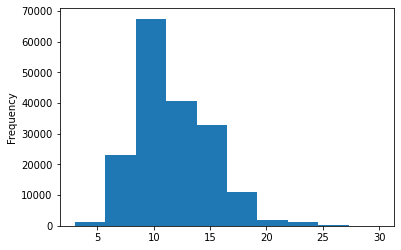

In [14]:
# Checking the Length of Lines
train_df.total_lines.plot.hist()

In [15]:
# Get the list of just the text Columns
train_sentences=train_df["text"].tolist()
test_sentences=test_df["text"].tolist()
val_sentences=val_df["text"].tolist()

In [16]:
len(train_sentences),len(test_sentences),len(val_sentences)

(180040, 30135, 30212)

In [17]:
# Turning the target Labels into Numeric Data
# We have 5 main labels -> Backgroun, Objective,Methods, Results, Conclusion
# We'll encode them both 1HEC and Simple Nuemrical
from sklearn.preprocessing import OneHotEncoder
# Tensorflow is incompaible with sparse matrices
one_hot_encoder=OneHotEncoder(sparse=False)
# You should reshape your X to be a 2D array not 1D array. Fitting a model requires requires a 2D array. i.e (n_samples, n_features)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot,val_labels_one_hot,test_labels_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [18]:
# Label Encoding also for Baseline Model
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train_labels_encoded=le.fit_transform(train_df["target"])
test_labels_encoded=le.fit_transform(test_df["target"])
val_labels_encoded=le.fit_transform(val_df["target"])
train_labels_encoded, test_labels_encoded,val_labels_encoded

(array([3, 2, 2, ..., 4, 1, 1]),
 array([0, 4, 4, ..., 4, 4, 1]),
 array([0, 0, 3, ..., 4, 1, 1]))

In [19]:
# Retieving classes 
num_classes=len(le.classes_)
class_names=le.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

<h3>  Model -> Naive Bayes Model </h3> <br>
<h4> TF-IDF Multinomial Naive Bayes Classifier </h4>

In [20]:
# Turning them to tensors
# Baseline Model
# tfidf turns text into Numbers with the Formula
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
# Creating a Pipeline
# A pipeline takes Multiple Tuples
model_0=Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
    
])
model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluation and Prediction
# In scikit learn it is score for eval
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [22]:
# Make Predictions for the Baseline Model
baseline_predictions=model_0.predict(val_sentences)
baseline_predictions

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
# Models for Calculating different evaluation metrics
# Returns a dict of different metrics
def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [24]:
calculate_results(val_labels_encoded,baseline_predictions)


{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

<h3> Conv 1D Model </h3>

In [25]:
# Vectorize the text and then create Embeddings
from tensorflow.keras import layers
# How long is each sentence on average
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_lens=np.mean(sent_lens)
avg_sent_lens
# sent_lens
#  So we will need Padding and Truncating as the input shapes must be maintained

26.338269273494777

(array([1.36848e+05, 3.91410e+04, 3.48700e+03, 4.52000e+02, 6.90000e+01,
        2.30000e+01, 1.40000e+01, 4.00000e+00, 2.00000e+00]),
 array([  1.        ,  33.77777778,  66.55555556,  99.33333333,
        132.11111111, 164.88888889, 197.66666667, 230.44444444,
        263.22222222, 296.        ]),
 <BarContainer object of 9 artists>)

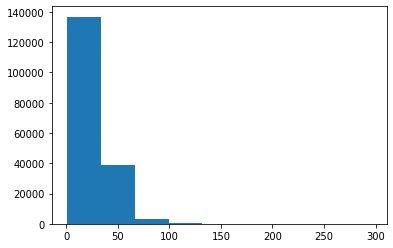

In [26]:
plt.hist(sent_lens,bins=9)

In [27]:
# Calculate the percentile of length of sentences
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len
# So 95% sentences are in length of 55

55

In [28]:
# Creating a text Vectorization Layer
# Mapping our text from words to Numbers
# An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. 
# Vocabulary size in the Research Paper is 68000
max_tokens=68000
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_tokens,output_sequence_length=output_seq_len)


2022-01-20 05:51:59.588081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 05:51:59.674986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 05:51:59.675701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 05:51:59.676841: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [29]:
# Adapt the Text Vectorizer to the Training Data
# We have to adapt it to only the training data so that val and test data are not seen
# Later it can be fitted to the two latter
text_vectorizer.adapt(train_sentences)

2022-01-20 05:52:04.186897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [30]:
# Finding out how many words are there  in the training vocabulary and which are  most common
# Also text vectorizer works pretty straightforwardly, 1 to most common word, 2 to 2nd most common word and so on
train_vocab=text_vectorizer.get_vocabulary()
# Size of Vocab
print(len(train_vocab))
# 5 Most Common Words in the Vocab
print(train_vocab[:5])
# Least common 5 words in the vocab
print(train_vocab[-5:])

64841
['', '[UNK]', 'the', 'and', 'of']
['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [31]:
# Get the config of our Text Vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False}

In [32]:
# Create an Embedding Layer
# More output dims , more emmbedding, more parameters to train
# Masking the 0 considering themm as padding
token_embed=layers.Embedding(input_dim=len(train_vocab),output_dim=128,mask_zero=True,name="token_embedding")

In [33]:
# Creating a Fast Loadinng Dataset with tf data API
# https://www.tensorflow.org/guide/data_performance
# https://www.tensorflow.org/guide/data
# Turn our data into Tensorflow datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset
# <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>
# Which indicates one Text Sample in first tuple, next tuple is (0,0,0,0,1) -> 1hc 

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [34]:
# Pre fetching the data and making them into batches
# Pre fetching reduces the Preparation time of Data taken by CPU
# Pref-fetching in a Multi-threaded way Reduces time and Increases the amount of data as all cores can be utilized to Prepare the Data
# The GPU will do the Computation
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset
# Run the Previous steps as well this otherwie the Shapes will not be fixed
# PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [35]:
# Creating the Model
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embedding=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embedding)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
# Indirect way of creating the Modelling the op ip
model_1=tf.keras.Model(inputs,outputs)
# Compiling the Model
model_1.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])



In [36]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [37]:
history_model_1=model_1.fit(train_dataset,epochs=5,validation_data=val_dataset)

Epoch 1/5


2022-01-20 05:52:19.432371: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5627/5627 [==============================] - 40s 6ms/step - loss: 0.6131 - accuracy: 0.7769 - val_loss: 0.5332 - val_accuracy: 0.8103
Epoch 2/5
5627/5627 [==============================] - 34s 6ms/step - loss: 0.4489 - accuracy: 0.8428 - val_loss: 0.5354 - val_accuracy: 0.8102
Epoch 3/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.3680 - accuracy: 0.8742 - val_loss: 0.5650 - val_accuracy: 0.8077
Epoch 4/5
5627/5627 [==============================] - 34s 6ms/step - loss: 0.3037 - accuracy: 0.8990 - val_loss: 0.6278 - val_accuracy: 0.8009
Epoch 5/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.2502 - accuracy: 0.9188 - val_loss: 0.7064 - val_accuracy: 0.7949


In [38]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.7064 - accuracy: 0.7949


[0.7064499855041504, 0.7948828339576721]

In [39]:
# Making Predictions In terms of Probabilities
model_1_prediction_probability=model_1.predict(val_dataset)
model_1_prediction_probability
# For all 30k statements our Model will output a 5 len list of Prediction Probability
# And out of the 5 the index that is higher is the one in which our class thinks the 
# Sentence belongs

array([[4.81434107e-01, 1.60569864e-04, 4.69450057e-01, 1.83521342e-02,
        3.06031238e-02],
       [3.78654480e-01, 4.56161685e-02, 2.04011961e-03, 5.68641067e-01,
        5.04817721e-03],
       [4.07513082e-02, 4.00878809e-04, 2.30424409e-03, 9.56508338e-01,
        3.52271891e-05],
       ...,
       [1.19482895e-08, 3.57755113e-07, 4.13434725e-04, 8.85003182e-09,
        9.99586165e-01],
       [3.99910398e-02, 2.26488099e-01, 6.38549507e-01, 5.84102469e-03,
        8.91303793e-02],
       [1.21392448e-04, 9.99447405e-01, 3.92146700e-04, 6.34812466e-07,
        3.83526312e-05]], dtype=float32)

In [40]:
# Now converting the Probabilities to classes
model_1_prediction=tf.argmax(model_1_prediction_probability,axis=1)
model_1_prediction

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 3, 3, ..., 4, 2, 1])>

In [41]:
model_1_results=calculate_results(y_true=val_labels_encoded,y_pred=model_1_prediction)
model_1_results

{'accuracy': 79.48828280153582,
 'precision': 0.7917066319030011,
 'recall': 0.7948828280153581,
 'f1': 0.7921590483096603}

<h3> Tensorflow Hub Pre trained Embedding and Feature Extractor </h3>

In [42]:

!pip install huggingface

In [43]:
# Model 2: Feature Extractor with pretrained token Embeddings
# This is done to leverage the power of Transfer Learning
import tensorflow_hub as hub
tf_hub_embedding_layers=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False,name="universal_sentence_encoder")

In [44]:
# Creating the Model
# For the Tensorflow embedding we are using the input shape needs to be in the form of an empty list
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layers(inputs)
x=layers.Dense(128,activation="relu")(pretrained_embedding)
x=layers.Dense(128,activation="relu")(x)
# Softmax because we are doing multiclass 
outputs=layers.Dense(5,activation="softmax")(x)
model_2=tf.keras.Model(inputs,outputs,name="model_2_transfer_learning")
# Compiling the Model
model_2.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
model_2.summary()

Model: "model_2_transfer_learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 256,880,645
Trainable params: 82,821
Non-trainable params: 256,797,824
_________________________________________________________________


In [45]:
# Fitting the Model
history_model_2=model_2.fit(train_dataset,epochs=9,validation_data=val_dataset)

Epoch 1/9
5627/5627 [==============================] - 80s 14ms/step - loss: 0.6920 - accuracy: 0.7338 - val_loss: 0.6264 - val_accuracy: 0.7595
Epoch 2/9
5627/5627 [==============================] - 79s 14ms/step - loss: 0.6048 - accuracy: 0.7693 - val_loss: 0.6021 - val_accuracy: 0.7701
Epoch 3/9
5627/5627 [==============================] - 83s 15ms/step - loss: 0.5707 - accuracy: 0.7834 - val_loss: 0.5999 - val_accuracy: 0.7713
Epoch 4/9
5627/5627 [==============================] - 82s 15ms/step - loss: 0.5471 - accuracy: 0.7931 - val_loss: 0.6041 - val_accuracy: 0.7718
Epoch 5/9
5627/5627 [==============================] - 80s 14ms/step - loss: 0.5288 - accuracy: 0.8004 - val_loss: 0.6083 - val_accuracy: 0.7716
Epoch 6/9
5627/5627 [==============================] - 83s 15ms/step - loss: 0.5126 - accuracy: 0.8071 - val_loss: 0.6164 - val_accuracy: 0.7697
Epoch 7/9
5627/5627 [==============================] - 82s 15ms/step - loss: 0.4986 - accuracy: 0.8123 - val_loss: 0.6247 - val_ac

In [46]:
# Evaluating on the Validation Set
model_2.evaluate(val_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.6411 - accuracy: 0.7668


[0.6410989761352539, 0.7668476104736328]

In [47]:
# Making Predictions In terms of Probabilities
model_2_prediction_probability=model_2.predict(val_dataset)
model_2_prediction_probability
# For all 30k statements our Model will output a 5 len list of Prediction Probability
# And out of the 5 the index that is higher is the one in which our class thinks the 
# Sentence belongs

array([[4.0803531e-01, 4.4367206e-01, 1.1133185e-05, 1.4820391e-01,
        7.7500437e-05],
       [5.9673101e-01, 2.2461630e-01, 1.1339488e-03, 1.7705977e-01,
        4.5888723e-04],
       [5.3690177e-01, 2.8190683e-03, 1.0214814e-02, 4.4736972e-01,
        2.6946557e-03],
       ...,
       [5.7643006e-06, 1.5147015e-05, 4.6100465e-04, 7.3555617e-07,
        9.9951732e-01],
       [5.0325323e-02, 3.3659038e-01, 2.5338400e-02, 7.5343540e-03,
        5.8021152e-01],
       [2.8704636e-04, 9.9971002e-01, 7.3130508e-07, 6.1276452e-08,
        1.9786214e-06]], dtype=float32)

In [48]:
# Now converting the Probabilities to classes
model_2_prediction=tf.argmax(model_2_prediction_probability,axis=1)
model_2_prediction

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 0, ..., 4, 4, 1])>

In [49]:
model_2_results=calculate_results(y_true=val_labels_encoded,y_pred=model_2_prediction)
model_2_results

{'accuracy': 76.68476102211042,
 'precision': 0.7665239601351793,
 'recall': 0.7668476102211041,
 'f1': 0.7643445637182193}

<h3> Building a Model with Character level Embeddings </h3>

In [50]:
# So we first need to build a Character Layer Tokenizer 
def split_chars(text):
    return " ".join(list(text))
# Text Splitting 
train_chars=[split_chars(sentence) for sentence in train_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [51]:
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]

In [52]:
# Finding the Average Character Length
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

290

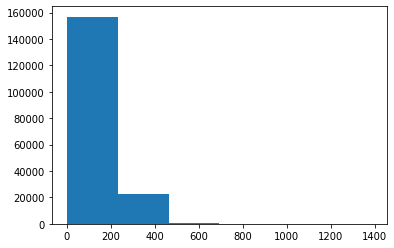

In [53]:
# The meann is not the best way to gauge so we need a distribution and should take 95% CI
plt.hist(char_lens,bins=6)

# Finding the 95% CI Length
ci_char_len=int(np.percentile(char_lens,95))
ci_char_len
# So 300 Characters must work

In [54]:
# Setting up a Text Vectorization Layer
# Getting the vocab size
import string
alphanumeric=string.ascii_lowercase+string.digits+string.punctuation
alphanumeric

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [55]:
# +2 for space and OOV UNK Token
max_char_vocab=len(alphanumeric)+2
char_vectorizer=TextVectorization(max_tokens=max_char_vocab,output_sequence_length=ci_char_len+10,name="char_vectorizer")
# Adapt it to the Training set of sequences
char_vectorizer.adapt(train_chars)

In [56]:
char_vocab=char_vectorizer.get_vocabulary()
print(len(char_vocab))
char_vocab[:5],char_vocab[-5:]

28


(['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [57]:
# Make an Embedding Layer
# As per the paper we have to make a 25 dim long Feature vector for Output dims
# Each character gets embedded into a size 25 Feature Vector
# Dont Mask Model 
char_embed=layers.Embedding(input_dim=len(char_vocab),output_dim=25,mask_zero=False,name="character_embedding")
 

In [58]:
# Creating character level Fast Loading Datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [59]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [60]:
# Building a BI-LSTM Model with the Character Level Embeddings
# Also experimenting with a Conv1D with Char level Embeddings
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")
# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 300)               0         
_________________________________________________________________
character_embedding (Embeddi (None, 300, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
___________________________________

In [62]:
model_3_history = model_3.fit(train_char_dataset,
                               epochs=6,
                               validation_data=val_char_dataset)

Epoch 1/6
5627/5627 [==============================] - 30s 5ms/step - loss: 0.8907 - accuracy: 0.6513 - val_loss: 0.7705 - val_accuracy: 0.7015
Epoch 2/6
5627/5627 [==============================] - 30s 5ms/step - loss: 0.7431 - accuracy: 0.7167 - val_loss: 0.7285 - val_accuracy: 0.7224
Epoch 3/6
5627/5627 [==============================] - 33s 6ms/step - loss: 0.7074 - accuracy: 0.7315 - val_loss: 0.7168 - val_accuracy: 0.7248
Epoch 4/6
5627/5627 [==============================] - 30s 5ms/step - loss: 0.6896 - accuracy: 0.7394 - val_loss: 0.7049 - val_accuracy: 0.7330
Epoch 5/6
5627/5627 [==============================] - 33s 6ms/step - loss: 0.6777 - accuracy: 0.7444 - val_loss: 0.7012 - val_accuracy: 0.7341
Epoch 6/6
5627/5627 [==============================] - 30s 5ms/step - loss: 0.6692 - accuracy: 0.7477 - val_loss: 0.6978 - val_accuracy: 0.7364


In the paper they have further used this BI-LSTM and then concatenated and then again passed it through another BILSTM Model.

In [63]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6978 - accuracy: 0.7364


[0.6977959275245667, 0.7364292144775391]

In [64]:
# Making Predictions In terms of Probabilities
model_3_prediction_probability=model_3.predict(val_char_dataset)
model_3_prediction_probability
# For all 30k statements our Model will output a 5 len list of Prediction Probability
# And out of the 5 the index that is higher is the one in which our class thinks the 
# Sentence belongs

array([[1.23507604e-01, 1.60980761e-01, 3.22536588e-01, 2.96243221e-01,
        9.67318490e-02],
       [6.89956471e-02, 9.13373411e-01, 4.39224794e-04, 1.54243885e-02,
        1.76722882e-03],
       [2.38851190e-01, 2.50393618e-02, 2.48533264e-02, 7.05088615e-01,
        6.16744719e-03],
       ...,
       [5.99018131e-05, 1.01888808e-03, 8.63253139e-04, 3.83623919e-05,
        9.98019576e-01],
       [1.62447821e-02, 4.22598049e-02, 5.67976236e-02, 9.71288420e-03,
        8.74984920e-01],
       [3.74004394e-02, 7.80454099e-01, 1.16809085e-01, 6.04681065e-03,
        5.92896044e-02]], dtype=float32)

In [65]:
# Now converting the Probabilities to classes
model_3_prediction=tf.argmax(model_3_prediction_probability,axis=1)
model_3_prediction

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 1, 3, ..., 4, 4, 1])>

In [66]:
model_3_results=calculate_results(y_true=val_labels_encoded,y_pred=model_3_prediction)
model_3_results

{'accuracy': 73.64292334171853,
 'precision': 0.7331572568768552,
 'recall': 0.7364292334171852,
 'f1': 0.7295907658237308}

<h3> Building a Model with Token + Character Embedding Model </h3>
<h4> Concatenating Models 

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

In [67]:
# Building a Tf Dataset to load it faster
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
# Preparing the same for Validation set
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [68]:
# Buidling a Multi Input Model that can accpet multiple data streams
# So we will build two BI-LSTM Models one with char embeddings and token Embeddings
# Also there is going to be a dropout introduced 
# One more difference is we will be using the functional API instead or Sequential API
# What it does is that it will go through steps together and not sequentially
# So first we will crate a Token Model
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings = tf_hub_embedding_layers(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_output)

In [69]:
# Then we will create a Character Model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
# The one with the char embeddings is passed through a BI-LSTM Model acc. to the Paper
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

In [70]:
# Concatenating both the Models as mentioned
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,char_model.output])

In [71]:
# Creating Combined Dropout and a dense Layer and then some dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) 
final_dropout = layers.Dropout(0.5)(combined_dense)
# Final Output, Label Pediction Layers
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [72]:
# 5. Construct model with char and token inputs
# 2 Inputs Token Model Input and Char Model Input 
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],outputs=output_layer,name="model_4_token_and_char_embeddings")

In [73]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 300)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

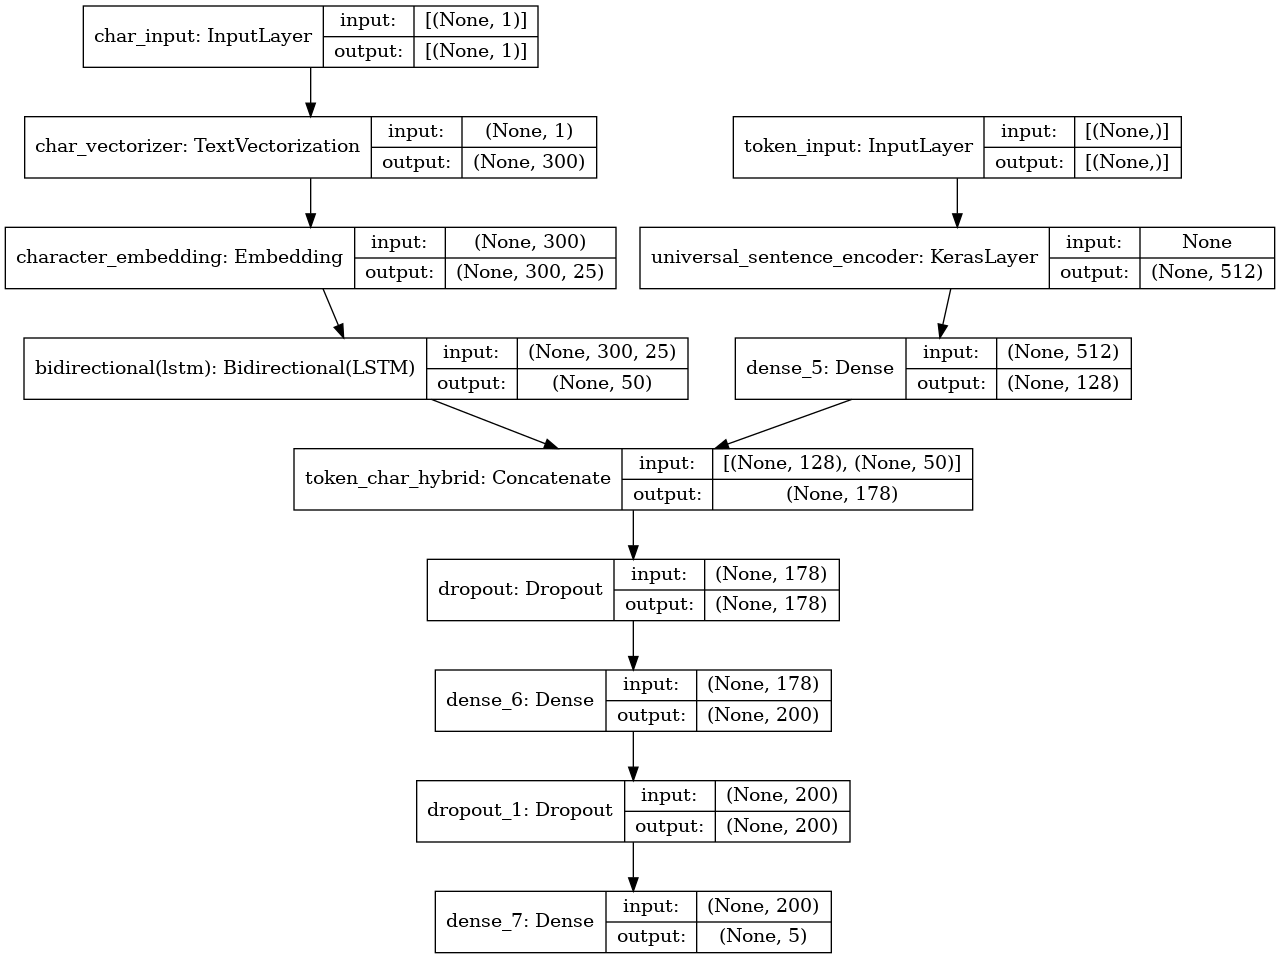

In [74]:
# Plot hybrid token and character model and check if it has replicated the Paper
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [75]:
# Compiling the Model
# None is the batch size in the shapes
model_4.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

In [76]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,epochs=5,validation_data=val_char_token_dataset)

Epoch 1/5
5627/5627 [==============================] - 217s 38ms/step - loss: 1.2378 - accuracy: 0.4913 - val_loss: 0.8963 - val_accuracy: 0.6393
Epoch 2/5
5627/5627 [==============================] - 217s 39ms/step - loss: 0.9188 - accuracy: 0.6329 - val_loss: 0.8115 - val_accuracy: 0.6834
Epoch 3/5
5627/5627 [==============================] - 220s 39ms/step - loss: 0.8553 - accuracy: 0.6661 - val_loss: 0.7729 - val_accuracy: 0.7026
Epoch 4/5
5627/5627 [==============================] - 216s 38ms/step - loss: 0.8187 - accuracy: 0.6836 - val_loss: 0.7435 - val_accuracy: 0.7170
Epoch 5/5
5627/5627 [==============================] - 218s 39ms/step - loss: 0.7938 - accuracy: 0.6946 - val_loss: 0.7246 - val_accuracy: 0.7240


In [77]:
# Caryying out similar exercise for Model 4
# model_4_prediction_probability=model_4.predict(val_char_dataset)
# model_4_prediction_probability
# model_4_prediction=tf.argmax(model_4_prediction_probability,axis=1)
# model_4_prediction
# model_4_results=calculate_results(y_true=val_labels_encoded,y_pred=model_4_prediction)
# model_4_results

<h3>Pretained Token Embeddings + Character Emebeddings + Positional Embeddings </h3>

In [78]:
# Feature Engineering
# Here we will take non obvious features from the Data and encoding them Numerically to aid the model
# The order of Objectives, Methods, Results conclusion sequence is a non obvious feature
# So we need to inject them into the Model and this is a part of the Feature Engineering
# Encoding the Line Numbers
# Engineering features incorporated need to be avaialable at test time
# Positional Embeddings
train_df["line_number"].value_counts()
# Almost 10K Abstracts have 10 + Lines

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [79]:
# Distribution
# Using TF To create one hot encoded tensors of Line Numbers
# They can be also used as it is the Lines they are but 1HC is better
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [80]:
# We need to this similarly for Total Lines
train_df["total_lines"].value_counts()
# We can take the Cutoff to e 20

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [81]:
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot,train_total_lines_one_hot.shape

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

In [82]:
# Buidling the Model
# Token Level Model + Character Level Model + Positional Models (2) -> Line Numbers and Total Lines
# Then we will Concatenate Model 1 and Model 2 
# Then Combine 3,4 and Combination of 1&2 
# Create an Output Layer
# # # Model 1 # # #
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_inputs")
token_embeddings=tf_hub_embedding_layers(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_outputs)
# Model 2 
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
# 24 cos 25-26 is the vocab size and we need multiples of 8
char_bilstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bilstm)

#  Model 3 and Model 4
# shape =(15,) as we have taken depth or size of line number till 15
line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_inputs")
x=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(line_number_inputs,x)

total_lines_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_inputs")
y=layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model=tf.keras.Model(total_lines_inputs,y)

# Concatenating the 1st and 2nd Model
combined_embeddings=layers.Concatenate(name="Hybrid_Merge_12")([token_model.output,char_model.output])
# Applying the Dropouts
z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)

# Combining all of the above 
final_embeddings=layers.Concatenate(name="char_token_positional_embeddings")([line_number_model.output,total_lines_model.output,z])

# Creating the Output Layer for accepting the above layers and giving Probabilities

output_layer=layers.Dense(5,activation="softmax",name="output_layer")(final_embeddings)
# Creating the Model
model_5=tf.keras.Model([line_number_model.input,total_lines_model.input,token_model.input,char_model.input],output_layer,name="model_5_tribrid_embedding_model")

In [83]:
# comma pachi je hoy e batch size maate hoy shapes ma
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 300)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

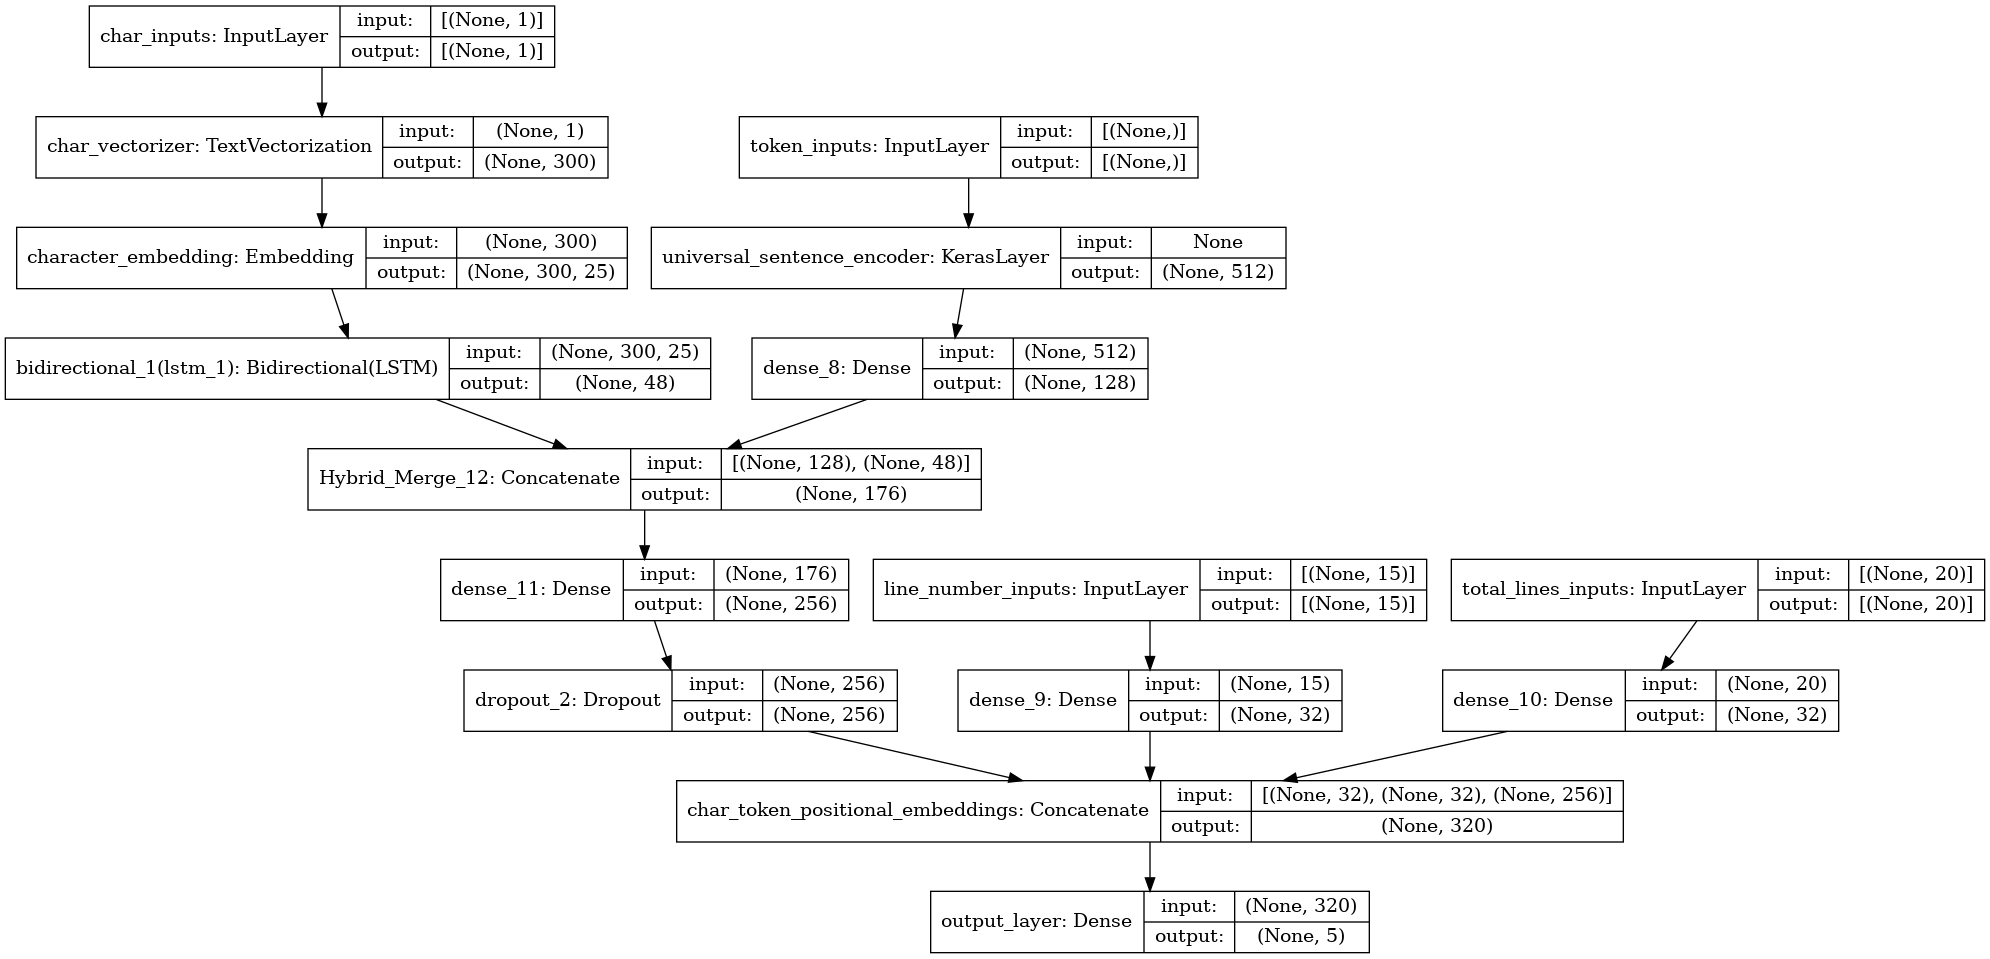

In [84]:
# Plot hybrid token and character model and check if it has replicated the Paper
from tensorflow.keras.utils import plot_model
plot_model(model_5,show_shapes=True)

In [85]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.SGD(),
               metrics=["accuracy"])
# Label Smoothing is a regularization technique that introduces noise for the labels.

In [86]:
# Creating Fast Loading Datasets for Model 5 with tf.data API
# ##### IMP IMP IMP IMP IMP IMP IMP IMP IMP IMP ###########
# The orders of line number, total lines, tokens, chars has been and must be maintained throughout the Model Operations
train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,val_chars))
val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_pos_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,test_total_lines_one_hot,test_sentences,test_chars))
test_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset=tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))
test_char_token_pos_dataset=test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [87]:
train_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [88]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=9,
                              validation_data=val_char_token_pos_dataset)


Epoch 1/9
5627/5627 [==============================] - 218s 38ms/step - loss: 1.2489 - accuracy: 0.6074 - val_loss: 1.0439 - val_accuracy: 0.7580
Epoch 2/9
5627/5627 [==============================] - 220s 39ms/step - loss: 1.0300 - accuracy: 0.7676 - val_loss: 0.9973 - val_accuracy: 0.7907
Epoch 3/9
5627/5627 [==============================] - 214s 38ms/step - loss: 1.0020 - accuracy: 0.7878 - val_loss: 0.9797 - val_accuracy: 0.8030
Epoch 4/9
5627/5627 [==============================] - 220s 39ms/step - loss: 0.9875 - accuracy: 0.7994 - val_loss: 0.9684 - val_accuracy: 0.8122
Epoch 5/9
5627/5627 [==============================] - 215s 38ms/step - loss: 0.9771 - accuracy: 0.8079 - val_loss: 0.9606 - val_accuracy: 0.8192
Epoch 6/9
5627/5627 [==============================] - 216s 38ms/step - loss: 0.9699 - accuracy: 0.8137 - val_loss: 0.9550 - val_accuracy: 0.8224
Epoch 7/9
5627/5627 [==============================] - 224s 40ms/step - loss: 0.9643 - accuracy: 0.8170 - val_loss: 0.9507 -

In [89]:
# Caryying out similar exercise for Model 4
model_5_prediction_probability=model_5.predict(val_char_dataset)
model_5_prediction_probability
model_5_prediction=tf.argmax(model_5_prediction_probability,axis=1)
model_5_prediction
model_5_results=calculate_results(y_true=val_labels_encoded,y_pred=model_5_prediction)
model_5_results

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:202 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_5_tribrid_embedding_model expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=string>]
